In [1]:
# Estudo: Deeplearning para Dados Tabulares - BASE AirPassengers_2
# Autor: Willian Oliveira
# Start: 25/02/2023
# Motivação: Avaliar desempenho de quatro abordagens para resolução de problematicas de séries temporais. 
# Status do Estudo: Em Andamento

In [2]:
# Importanto bibliotecas para manipulação e análise de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

# Configurando tamanho dos gráficos
rcParams['figure.figsize'] = 15, 8

# Importando bibliotecas para fixar SEED e reprodutibilidade do código
import tensorflow as tf
import os
import random

SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED) # Fixando seed para resultados reprodutíveis.

# Reduzindo warning para melhor legibilidade dos outputs
import  warnings 
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)


## Definindo Utilitarios

In [3]:
def avaliaModelo(validation_data, validation_predictions, test_data, test_predictions):
    """Exibe os resultados das métricas de avaliação do treinamento e armazena seus valores em um dicionário."""

    from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

    validation_mse = mean_squared_error(validation_data, validation_predictions)
    validation_mape = mean_absolute_percentage_error(validation_data, validation_predictions)
    test_mse = mean_squared_error(test_data, test_predictions)
    test_mape = mean_absolute_percentage_error(test_data, test_predictions)

    print("Validation MSE: ", validation_mse)
    print("Validation MAPE: ", validation_mape)
    print("Test MSE: ", test_mse)
    print("Test MAPE: ", test_mape)

    return {'Validation MSE': validation_mse,
            'Validation MAPE': validation_mape,
            'Test MSE': test_mse,
            'Test MAPE': test_mape}

def missingValues(df):
    """Exibe percentual de valores faltantes por coluna do dataset."""

    from IPython.display import display, Markdown

    missing_values = df.isnull().sum() / len(df)*100
    missing_values = missing_values.sort_values(ascending=False)
    missing_values.rename("% missing values", inplace=True)
    display(Markdown(missing_values.to_markdown()))
    del missing_values


## AED e Pré-Processamento Básico

* Divida a série nos conjuntos de treinamento, validação e teste com as seguintes porcentagens: 50%, 25% e 25%, seguindo a ordem temporal.
* Compreenda a natureza da base de dados e seu comportamento visual.
* Desenvolva, avalie e compare os modelos no cenário da previsão de um passo à frente.

In [4]:
import statsmodels.tsa.api as tsa

# Importando a base e explorando a série para melhor entendimento da natureza do estudo
PATH = 'Data\AirPassengers_2.csv'
BASE_NAME = 'AirPassengers_2'
df = pd.read_csv(PATH)
df.head()


,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


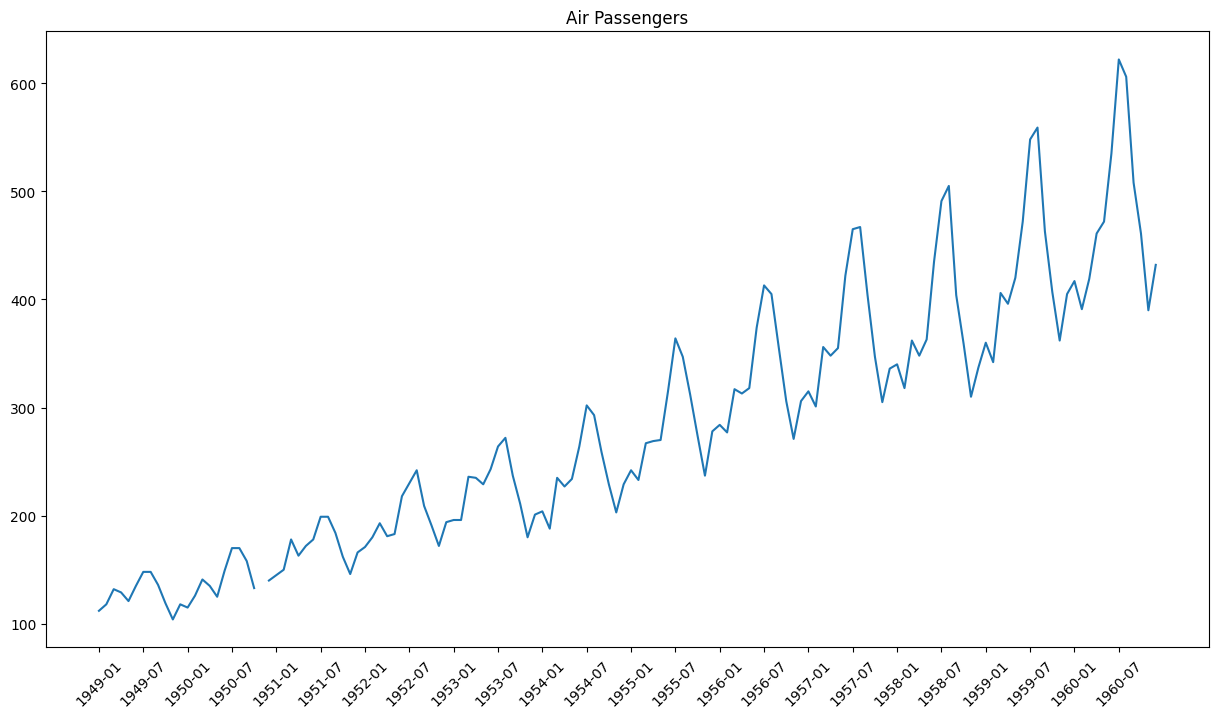

In [5]:
# Organizando e plotando a série para análise visual.
df = df.set_index('Month')
plt.plot(df)
plt.title('Air Passengers')
plt.xticks(np.arange(0, len(df), 6), rotation=45)
plt.show()

In [6]:
# Avaliando estatísticas básicas da série
df.describe()

,Passengers
count,143.000000
mean,281.461538
std,119.570697
min,104.000000
25%,180.500000
50%,267.000000
75%,361.000000
max,622.000000


In [7]:
# Verificando % de valores faltantes
missingValues(df)

|            |   % missing values |
|:-----------|-------------------:|
| Passengers |           0.694444 |

In [8]:
# Preenchendo valores faltantes com o primeiro valor válido imediatamente anterior aos valores NaN para manter a série contínua.
df = df.fillna(method='ffill')

In [9]:
# Dividindo a série em Treinamento, Validação e Teste, conforme as proporções solicitadas
train_data = df[:int(0.5 * len(df))]
validation_data = df[int(0.5 * len(df)):int(0.75 * len(df))]
test_data = df[int(0.75 * len(df)):]

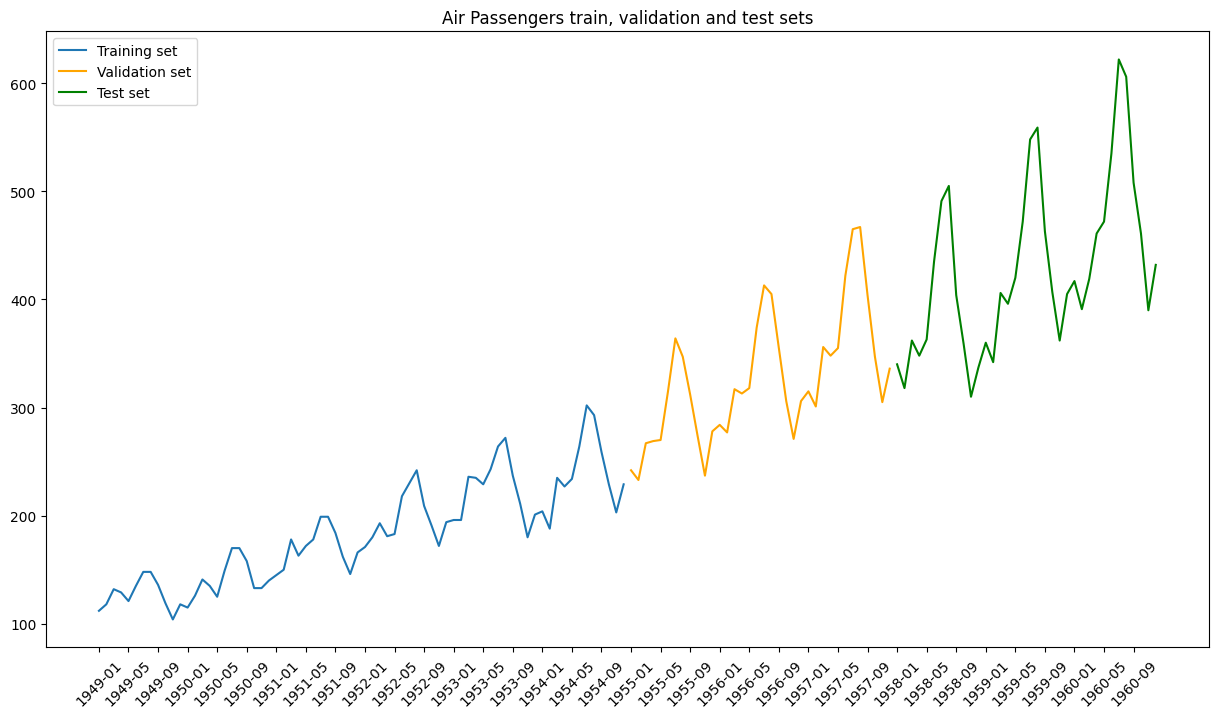

In [10]:
# Visualizando as séries de treinamento, validação e teste
plt.title('Air Passengers train, validation and test sets')
plt.plot(train_data, label='Training set')
plt.plot(validation_data, label='Validation set', color='orange')
plt.plot(test_data, label='Test set', color='green')
plt.legend()
plt.xticks(np.arange(0, len(df), len(df)/36), rotation=45)
plt.show()

In [11]:
%%time

validation_naive_forecast_prediction = validation_data[:-1]
test_naive_forecast_prediction = test_data[:-1]
naive_results = avaliaModelo(validation_data=validation_data[1:], 
                             validation_predictions=validation_naive_forecast_prediction, 
                             test_data=test_data[1:], 
                             test_predictions=test_naive_forecast_prediction)


Validation MSE:  1290.6857142857143
Validation MAPE:  0.0898720645390058
Test MSE:  2601.885714285714
Test MAPE:  0.10080826084871936
CPU times: total: 0 ns
Wall time: 83.1 ms


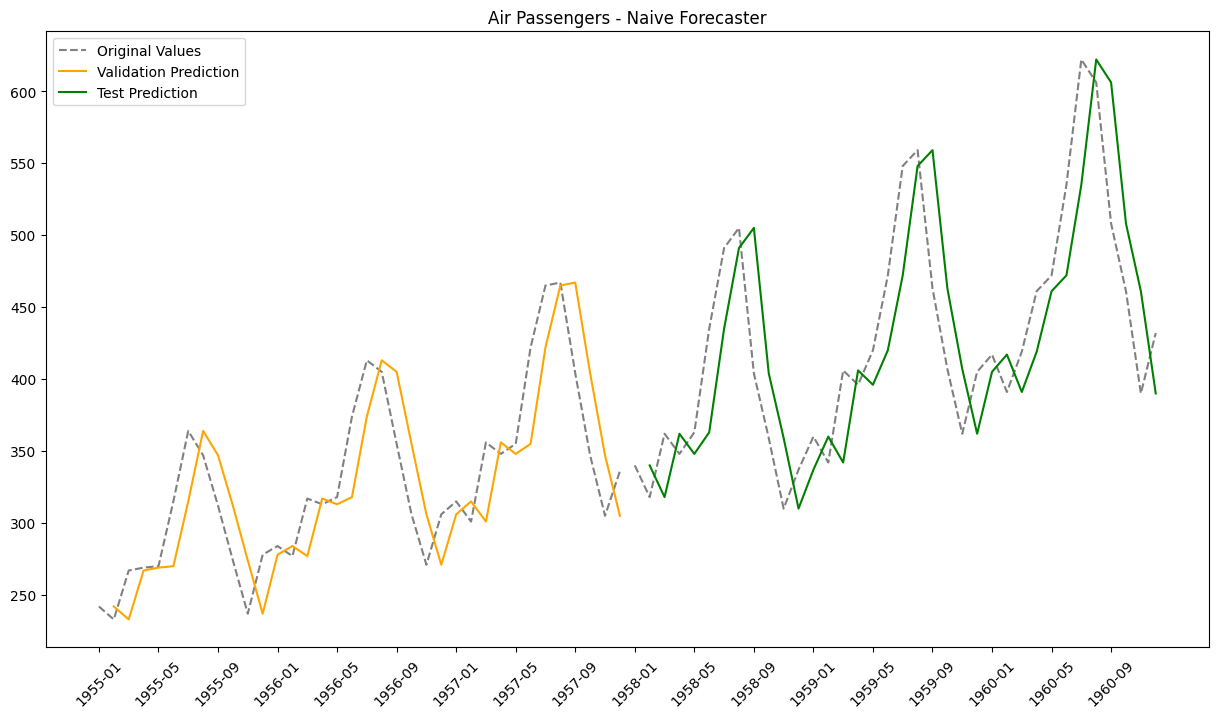

In [12]:
# Visualizando as previsões para os datasets de validação e teste.

plt.title('Air Passengers - Naive Forecaster')
plt.plot(validation_data.index, validation_data, label='Original Values', color='gray', linestyle='dashed')
plt.plot(test_data.index, test_data, color='gray', linestyle='dashed')
plt.plot(validation_data.index[1:], validation_naive_forecast_prediction, label='Validation Prediction', color='orange')
plt.plot(test_data.index[1:], test_naive_forecast_prediction, label='Test Prediction', color='green')
plt.legend()
plt.xticks(np.arange(0, len(df)/2, len(df)/36), rotation=45)
plt.xlim
plt.show()

## 1) Estimação de um modelo estatístico linear

* Faça todo pré-processamento necessário para treinar um modelo ARIMA utilizando a metodologia de Box & Jenkins.
* Escolha o modelo mais adequado para fazer a previsão no conjunto de teste a partir do erro no conjunto de treinamento e da série de resíduos.
* Gere os erros de previsão e gráficos para o conjunto de treinamento e teste. Sugestão: erro quadrático médio (EQM, ou MSE em inglês) e mean absolute percentage error (MAPE).

In [13]:
%%time
import pmdarima as pm

# Ajustando o modelo ARIMA aos dados de treinamento training
modelo_autoarima = pm.auto_arima(train_data, max_p=5 , max_q=5, max_d=5
                                 , max_P=5, max_Q=5, max_D=5, m=12
                                 , seasonal=False, trace=True
                                 , information_criterion='bic'
                                 , stepwise=True)

modelo_autoarima.fit(train_data)



Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=613.547, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=626.065, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=628.119, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=627.364, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=622.350, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : BIC=inf, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : BIC=inf, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : BIC=inf, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : BIC=inf, Time=0.12 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 1.730 seconds
CPU ti

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

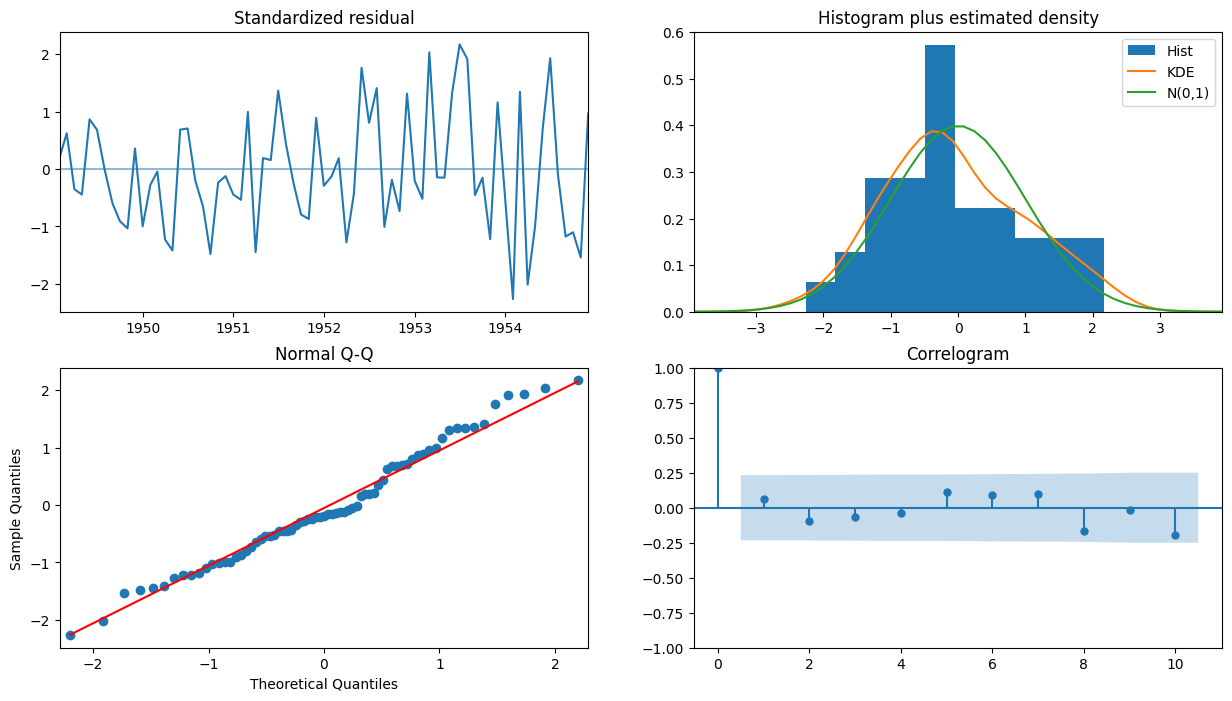

In [14]:
modelo_autoarima.plot_diagnostics();

In [15]:
# Fazendo previsões com o modelo ARIMA
validation_ARIMA_prediction= modelo_autoarima.predict(len(validation_data))
test_ARIMA_prediction = modelo_autoarima.predict(len(test_data))

# Calculando mean squared error (MSE) e mean absolute percentage error (MAPE) para os datasets de validação e teste
resultado_arima = avaliaModelo(validation_data, validation_ARIMA_prediction, test_data, test_ARIMA_prediction)


Validation MSE:  3392.213774796291
Validation MAPE:  0.11312168291315988
Test MSE:  22673.320965246185
Test MAPE:  0.29547541745872496


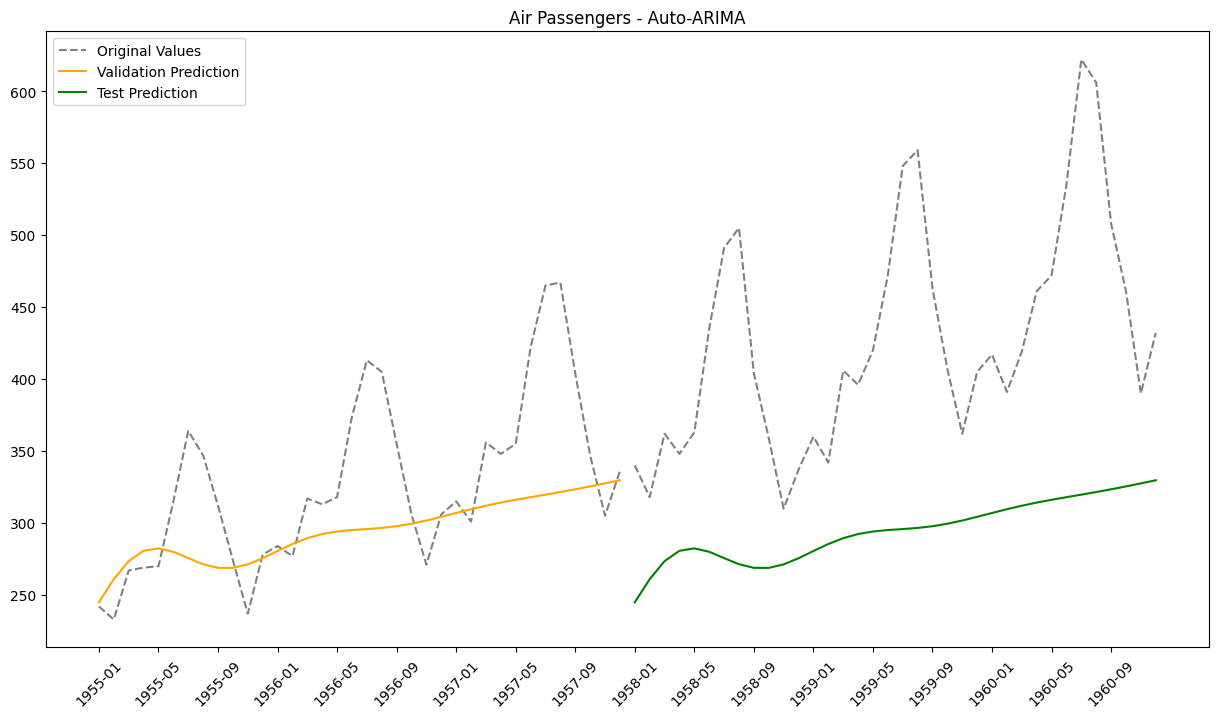

In [16]:
# Visualizando as previsões para os datasets de validação e teste.
plt.title('Air Passengers - Auto-ARIMA')
plt.plot(validation_data.index, validation_data, label='Original Values', color='gray', linestyle='dashed')
plt.plot(test_data.index, test_data, color='gray', linestyle='dashed')
plt.plot(validation_data.index, validation_ARIMA_prediction, label='Validation Prediction', color='orange')
plt.plot(test_data.index, test_ARIMA_prediction, label='Test Prediction', color='green')
plt.legend()
plt.xticks(np.arange(0, len(df)/2, len(df)/36), rotation=45)
plt.xlim
plt.show()

In [17]:
%%time
# Realizando teste com SARIMA
modelo_autosarima = pm.auto_arima(train_data, max_p=5 , max_q=5, max_d=5
                                 , max_P=5, max_Q=5, max_D=5, m=12
                                 , seasonal=True, trace=True
                                 , information_criterion='bic'
                                 , stepwise=True)
                                 
# Ajustando o modelo SARIMA aos dados de treinamento training
modelo_autosarima.fit(train_data)


Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : BIC=484.483, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : BIC=452.409, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : BIC=467.046, Time=0.12 sec
 ARIMA(0,0,0)(0,1,0)[12]             : BIC=564.632, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : BIC=457.320, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : BIC=456.451, Time=0.37 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : BIC=456.447, Time=0.23 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : BIC=453.091, Time=0.15 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : BIC=460.541, Time=0.75 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : BIC=477.620, Time=0.11 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : BIC=453.513, Time=0.20 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : BIC=454.731, Time=0.20 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : BIC=466.139, Time=0.13 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True)

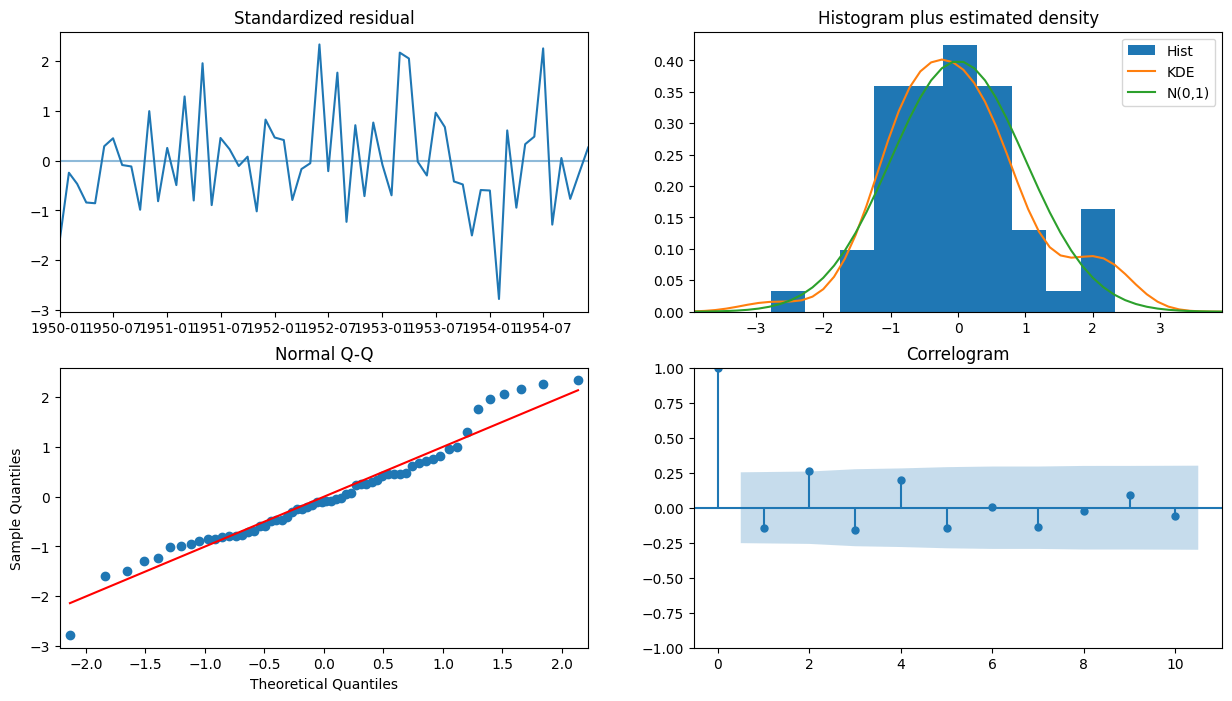

In [18]:
modelo_autosarima.plot_diagnostics();

In [19]:
# Fazendo previsões com o modelo SARIMA
validation_SARIMA_prediction= modelo_autosarima.predict(len(validation_data))
test_SARIMA_prediction = modelo_autosarima.predict(len(test_data))

# Calculando mean squared error (MSE) e mean absolute percentage error (MAPE) para os datasets de validação e teste
resultado_sarima = avaliaModelo(validation_data, validation_SARIMA_prediction, test_data, test_SARIMA_prediction)

Validation MSE:  2130.396601179935
Validation MAPE:  0.11130871506616355
Test MSE:  21704.083648509204
Test MAPE:  0.32169074961563954


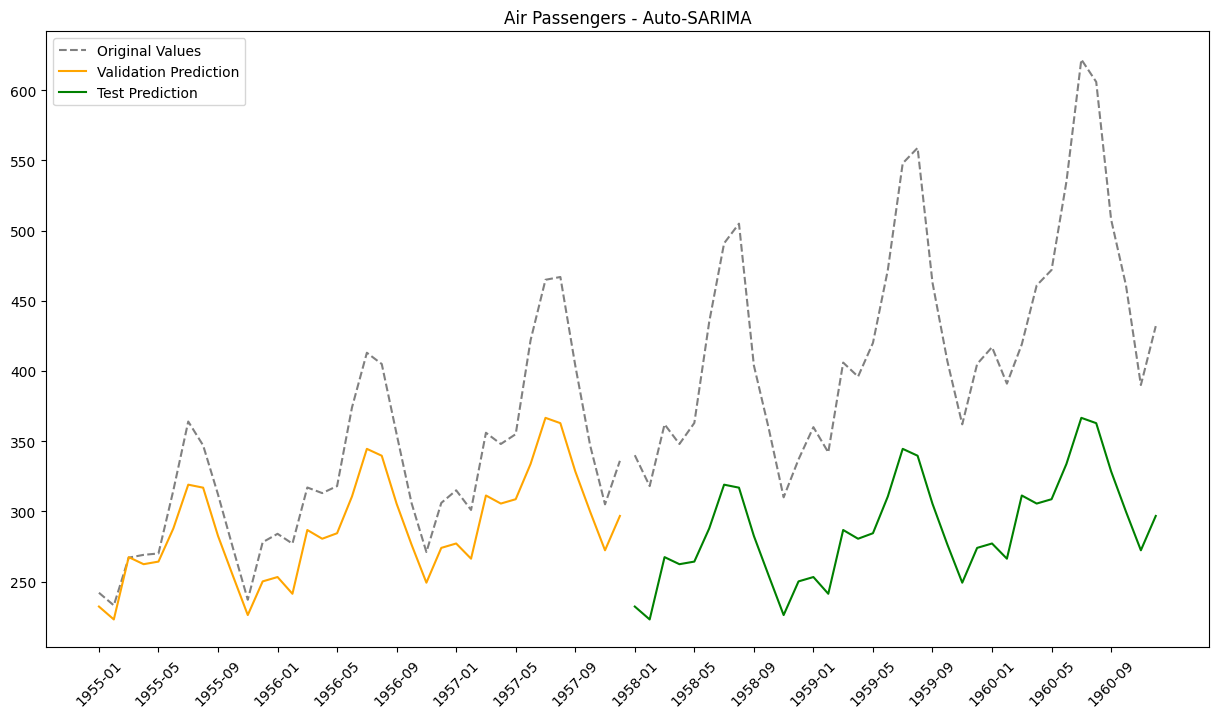

In [20]:
# Visualizando as previsões para os datasets de validação e teste.
plt.title('Air Passengers - Auto-SARIMA')
plt.plot(validation_data.index, validation_data, label='Original Values', color='gray', linestyle='dashed')
plt.plot(test_data.index, test_data, color='gray', linestyle='dashed')
plt.plot(validation_data.index, validation_SARIMA_prediction, label='Validation Prediction', color='orange')
plt.plot(test_data.index, test_SARIMA_prediction, label='Test Prediction', color='green')
plt.legend()
plt.xticks(np.arange(0, len(df)/2, len(df)/36), rotation=45)
plt.xlim
plt.show()

## 2) Treinamento de três modelos de Aprendizado de Máquina
* Faça todo pré-processamento necessário para treinar uma Rede Neural Multilayer Perceptron, ou uma Support Vector Regression, e dois modelos de Aprendizado Profundo (Convolutional Neural Network, Long Short Term Memory ou Transformer).
* Utilize um grid search/random search para estabelecer os parâmetros do modelo.
* Utilize o conjunto de validação para selecionar o melhor modelo.
* Gere os erros de previsão e gráficos para o conjunto de treinamento, validação e teste. 

Sugestão: erro quadrático médio (EQM, ou MSE em inglês) e mean absolute percentage error (MAPE).

### Pre-processamento

In [21]:
# Realizando janelamento no dataset completo, pois temos poucas observações.
def get_lags(series, lags):
    result = []
    if lags > 0:
        for lag in range(1, lags+1):
            result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
        return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
    else:
        for lag in range(-1, lags-1,-1):
            result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
        return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()


WINDOW_SIZE = 12

sliding_windows_df = get_lags(df, WINDOW_SIZE)
X = sliding_windows_df
y = df.reindex(X.index)

In [22]:
# Visualizando o resultado do janelamento
for i in range(5):
    print(f'Window: {X.values.tolist()[i]} -> Label: {y.values.tolist()[i]}')

Window: [118.0, 104.0, 119.0, 136.0, 148.0, 148.0, 135.0, 121.0, 129.0, 132.0, 118.0, 112.0] -> Label: [115.0]
Window: [115.0, 118.0, 104.0, 119.0, 136.0, 148.0, 148.0, 135.0, 121.0, 129.0, 132.0, 118.0] -> Label: [126.0]
Window: [126.0, 115.0, 118.0, 104.0, 119.0, 136.0, 148.0, 148.0, 135.0, 121.0, 129.0, 132.0] -> Label: [141.0]
Window: [141.0, 126.0, 115.0, 118.0, 104.0, 119.0, 136.0, 148.0, 148.0, 135.0, 121.0, 129.0] -> Label: [135.0]
Window: [135.0, 141.0, 126.0, 115.0, 118.0, 104.0, 119.0, 136.0, 148.0, 148.0, 135.0, 121.0] -> Label: [125.0]


In [23]:
# Dividindo o dataset em partes de treino, validação e teste conforme percentuais solicitados na atividade
def make_train_test_splits(windows, labels, validadation_split=0.25, test_split=0.25):

  train_windows = windows[:int((1-(validadation_split + test_split)) * len(df))]
  train_labels = labels[:int((1-(validadation_split + test_split)) * len(df))]
  validation_windows = windows[int((1-(validadation_split + test_split)) * len(df)):int((1-test_split) * len(df))]
  validation_labels = labels[int((1-(validadation_split + test_split)) * len(df)):int((1-test_split) * len(df))]
  test_windows = windows[int((1-test_split) * len(df)):]
  test_labels = labels[int((1-test_split) * len(df)):]
  
  return train_windows, test_windows, validation_windows, validation_labels, train_labels, test_labels
  
train_windows, test_windows, validation_windows, validation_labels, train_labels, test_labels = make_train_test_splits(X, y)
len(train_windows), len(validation_windows), len(test_windows), len(train_labels), len(validation_labels), len(test_labels)

(72, 36, 24, 72, 36, 24)

In [24]:
# Visualizando os datasets
print('Training Set Sample:')
for i in range(5):
    print(f'Window: {train_windows.values.tolist()[i]} -> Label: {train_labels.values.tolist()[i]}')
print('\nValidation Set Sample:')
for i in range(5):
    print(f'Window: {validation_windows.values.tolist()[i]} -> Label: {validation_labels.values.tolist()[i]}')
print('\nTest Set Sample:')
for i in range(5):
    print(f'Window: {test_windows.values.tolist()[i]} -> Label: {test_labels.values.tolist()[i]}')

Training Set Sample:
Window: [118.0, 104.0, 119.0, 136.0, 148.0, 148.0, 135.0, 121.0, 129.0, 132.0, 118.0, 112.0] -> Label: [115.0]
Window: [115.0, 118.0, 104.0, 119.0, 136.0, 148.0, 148.0, 135.0, 121.0, 129.0, 132.0, 118.0] -> Label: [126.0]
Window: [126.0, 115.0, 118.0, 104.0, 119.0, 136.0, 148.0, 148.0, 135.0, 121.0, 129.0, 132.0] -> Label: [141.0]
Window: [141.0, 126.0, 115.0, 118.0, 104.0, 119.0, 136.0, 148.0, 148.0, 135.0, 121.0, 129.0] -> Label: [135.0]
Window: [135.0, 141.0, 126.0, 115.0, 118.0, 104.0, 119.0, 136.0, 148.0, 148.0, 135.0, 121.0] -> Label: [125.0]

Validation Set Sample:
Window: [278.0, 237.0, 274.0, 312.0, 347.0, 364.0, 315.0, 270.0, 269.0, 267.0, 233.0, 242.0] -> Label: [284.0]
Window: [284.0, 278.0, 237.0, 274.0, 312.0, 347.0, 364.0, 315.0, 270.0, 269.0, 267.0, 233.0] -> Label: [277.0]
Window: [277.0, 284.0, 278.0, 237.0, 274.0, 312.0, 347.0, 364.0, 315.0, 270.0, 269.0, 267.0] -> Label: [317.0]
Window: [317.0, 277.0, 284.0, 278.0, 237.0, 274.0, 312.0, 347.0, 36

### Suport Vector Regression

In [25]:
%%time

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10]}
svr = SVR()
reg = GridSearchCV(svr, parameters)
reg.fit(train_windows, train_labels.to_numpy().ravel())

print('Melhores parâmetros:', reg.best_params_)

Melhores parâmetros: {'C': 10, 'kernel': 'linear'}
CPU times: total: 10.6 s
Wall time: 11 s


In [26]:
SVR_val_preds = reg.predict(validation_windows)
SVR_test_preds = reg.predict(test_windows)

SVR_model_results = avaliaModelo(validation_data=tf.squeeze(validation_labels), 
                                 validation_predictions=SVR_val_preds,
                                 test_data=tf.squeeze(test_labels),
                                 test_predictions= SVR_test_preds)

Validation MSE:  567.6215494479912
Validation MAPE:  0.051639016308594035
Test MSE:  479.5784156712263
Test MAPE:  0.039937594042699844


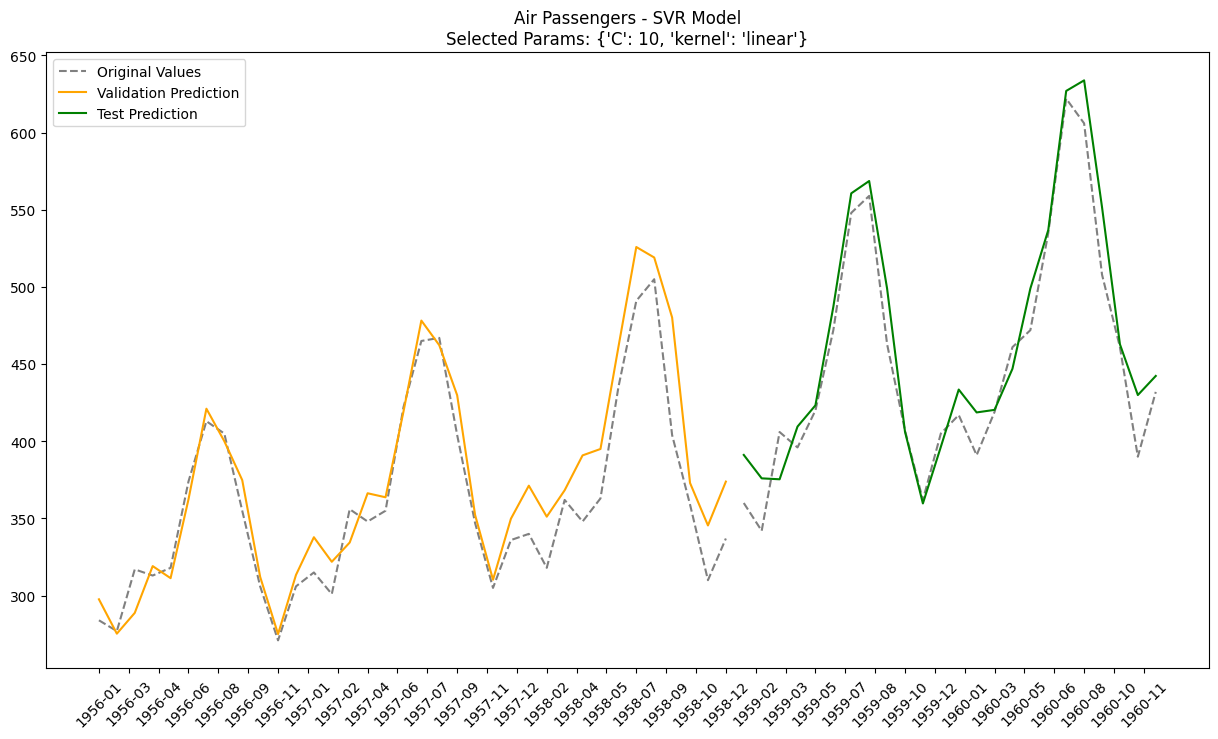

In [27]:
# Visualizando as previsões para os datasets de validação e teste
plt.title(f'Air Passengers - SVR Model\nSelected Params: {reg.best_params_}')
plt.plot(validation_windows.index, validation_labels, label='Original Values', color='gray', linestyle='dashed')
plt.plot(test_windows.index, test_labels, color='gray', linestyle='dashed')
plt.plot(validation_windows.index, SVR_val_preds, label='Validation Prediction', color='orange')
plt.plot(test_windows.index, SVR_test_preds, label='Test Prediction', color='green')
plt.legend()
plt.xticks(np.arange(0, len(validation_windows)+len(test_windows), (len(validation_windows) + len(test_windows))/36), rotation=45)
plt.xlim
plt.show()

### Convolutional Neural Network

In [28]:
%%time

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.initializers import HeNormal
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Criando a arquitetura CNN com uso do KerasRegressor para poder utilizar o GridSearchCV

def cnn_model(filters=32, kernel_size=3, pool_size=2, dense_units=32):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(WINDOW_SIZE, 1)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

cnn = KerasRegressor(build_fn=cnn_model, filters=32, kernel_size=3, pool_size=2, dense_units=32, epochs=500, verbose=0)

# Define a pipeline para o GridSearchCV
pipeline = Pipeline([
    ('cnn', cnn)
])

param_grid = {'cnn__filters': [32, 64],
              'cnn__kernel_size': [3, 5],
              'cnn__dense_units': [128, 256],
              'cnn__epochs': [250, 500]}

CNN_model = GridSearchCV(pipeline, param_grid=param_grid, cv=3)

CNN_model.fit(train_windows, train_labels)

print('Melhores parâmetros:', CNN_model.best_params_)

Melhores parâmetros: {'cnn__dense_units': 256, 'cnn__epochs': 500, 'cnn__filters': 64, 'cnn__kernel_size': 3}
CPU times: total: 24.3 s
Wall time: 1min 10s


In [29]:
CNN_model_val_preds = CNN_model.predict(validation_windows)
CNN_model_test_preds = CNN_model.predict(test_windows)

CNN_model_results = avaliaModelo(validation_data=tf.squeeze(validation_labels), 
                                     validation_predictions=CNN_model_val_preds,
                                     test_data=tf.squeeze(test_labels),
                                     test_predictions=CNN_model_test_preds)

Validation MSE:  438.465005534106
Validation MAPE:  0.044139917595179844
Test MSE:  358.79811661387794
Test MAPE:  0.03715968698804362


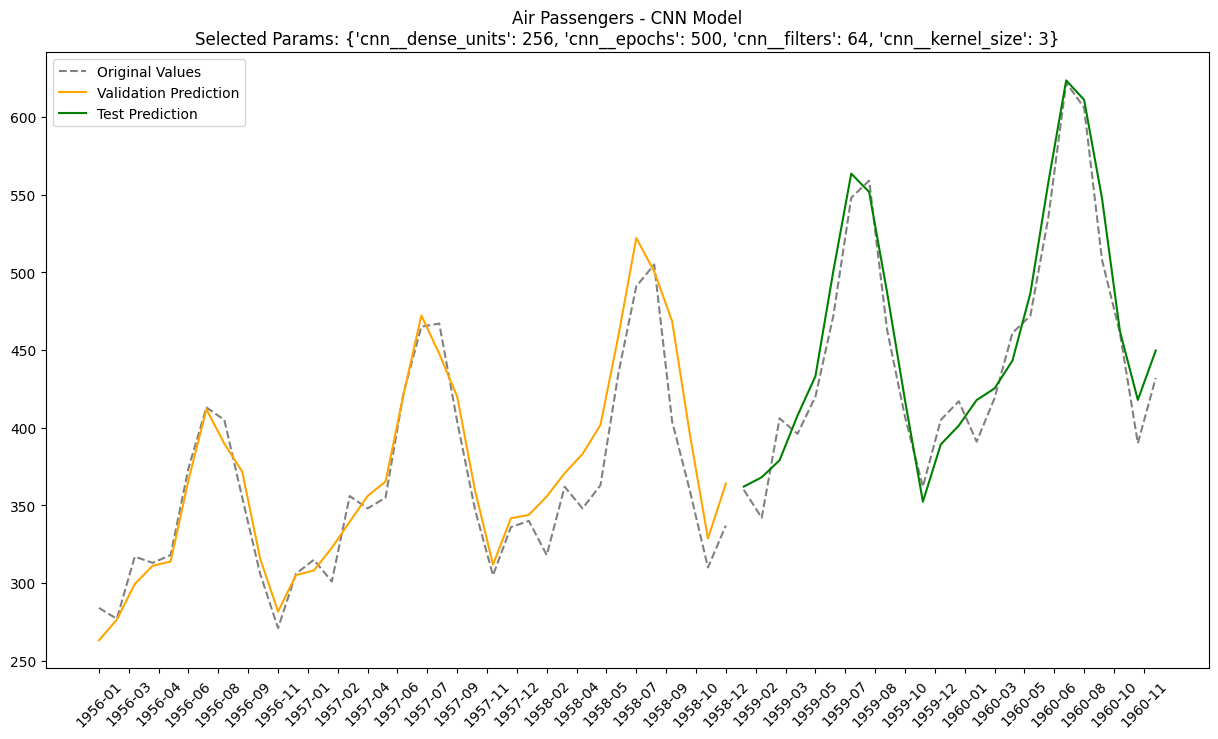

In [30]:
# Visualizando as previsões para os datasets de validação e teste.
plt.title(f'Air Passengers - CNN Model\nSelected Params: {CNN_model.best_params_}')
plt.plot(validation_windows.index, validation_labels, label='Original Values', color='gray', linestyle='dashed')
plt.plot(test_windows.index, test_labels, color='gray', linestyle='dashed')
plt.plot(validation_windows.index, CNN_model_val_preds, label='Validation Prediction', color='orange')
plt.plot(test_windows.index, CNN_model_test_preds, label='Test Prediction', color='green')
plt.legend()
plt.xticks(np.arange(0, len(validation_windows)+len(test_windows), (len(validation_windows) + len(test_windows))/36), rotation=45)
plt.xlim
plt.show()

### Long Short Term Memory

In [36]:
%%time

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor
from keras.initializers import HeNormal
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define a arquitetura do modelo LSTM com Keras
def lstm_model(neurons=50):
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', kernel_initializer = HeNormal(42), input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Cria um objeto KerasRegressor para usar com GridSearchCV
lstm = KerasRegressor(build_fn=lstm_model, batch_size=1, epochs=750, verbose=0, neurons=50)

# Desenvolve TransformadorMixin para retirar tendência dos dados
from sklearn.base import TransformerMixin

class LinearRegressorTransformer(TransformerMixin):
    def __init__(self, degree=1):
        self.poly = PolynomialFeatures(degree=degree, include_bias=False)
        self.lr = LinearRegression()

    def fit(self, X, y):
        X_poly = self.poly.fit_transform(X)
        self.lr.fit(X_poly, y)
        return self

    def transform(self, X):
        X_poly = self.poly.transform(X)
        return self.lr.predict(X_poly)

# Define a pipeline para o GridSearchCV
pipeline = Pipeline([
    ('trend', LinearRegressorTransformer(degree=1)),
    ('lstm', lstm)
])


# Define a lista de parâmetros para o GridSearchCV
param_grid = {
    'lstm__neurons': [50, 100],
    'lstm__epochs': [500, 750]
}

# Cria o objeto GridSearchCV
LSTM_model = GridSearchCV(pipeline, param_grid=param_grid, cv=3)

# Treina o modelo com GridSearchCV
LSTM_model.fit(train_windows, train_labels)


# Imprime os resultados
print(f"Melhores parâmetros: {LSTM_model.best_params_}")



Melhores parâmetros: {'lstm__epochs': 500, 'lstm__neurons': 100}
CPU times: total: 37.1 s
Wall time: 5min 40s


In [37]:
# Realizando previsões e avaliando métricas do modelo
LSTM_model_val_preds = LSTM_model.predict(validation_windows)
LSTM_model_test_preds = LSTM_model.predict(test_windows)

LSTM_model_results = avaliaModelo(validation_data=tf.squeeze(validation_labels), 
                                     validation_predictions=LSTM_model_val_preds,
                                     test_data=tf.squeeze(test_labels),
                                     test_predictions=LSTM_model_test_preds)

Validation MSE:  386.05284730758933
Validation MAPE:  0.040821339750132996
Test MSE:  283.8490096116827
Test MAPE:  0.02801124040940829


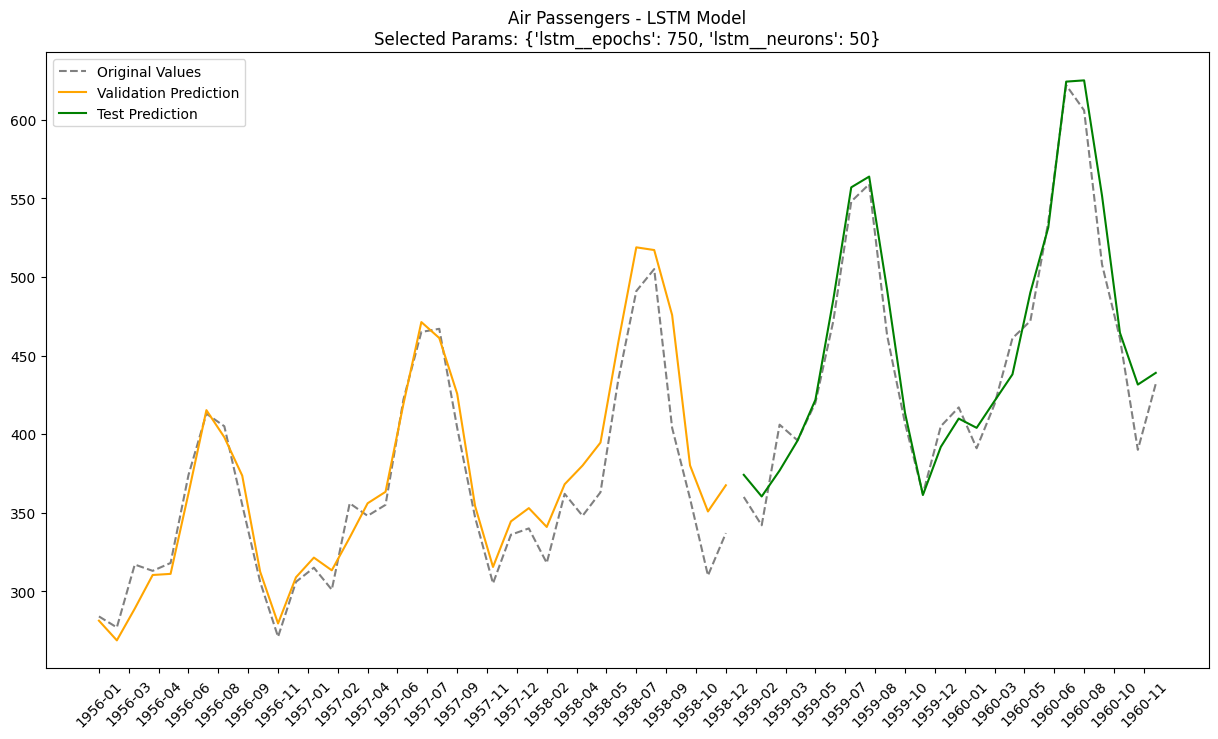

In [33]:
# Visualizando as previsões para os datasets de validação e teste.
plt.title(f'Air Passengers - LSTM Model\nSelected Params: {LSTM_model.best_params_}')
plt.plot(validation_windows.index, validation_labels, label='Original Values', color='gray', linestyle='dashed')
plt.plot(test_windows.index, test_labels, color='gray', linestyle='dashed')
plt.plot(validation_windows.index, LSTM_model_val_preds, label='Validation Prediction', color='orange')
plt.plot(test_windows.index, LSTM_model_test_preds, label='Test Prediction', color='green')
plt.legend()
plt.xticks(np.arange(0, len(validation_windows)+len(test_windows), (len(validation_windows) + len(test_windows))/36), rotation=45)
plt.xlim
plt.show()

In [34]:
naive_results = pd.DataFrame(naive_results, index=[0])
ARIMA_results = pd.DataFrame(resultado_arima, index=[1])
SARIMA_results = pd.DataFrame(resultado_sarima, index=[2])
SVR_results = pd.DataFrame(SVR_model_results, index=[3])
CNN_results =  pd.DataFrame(CNN_model_results, index=[4])
LSTM_results =  pd.DataFrame(LSTM_model_results, index=[5])

In [38]:
results = pd.concat([naive_results, ARIMA_results, SARIMA_results, SVR_results, CNN_results, LSTM_results])
results['Modelo'] = pd.DataFrame(['Naive Forecast', 'ARIMA', 'SARIMA', 'SVR', 'CNN', 'LSTM'])
results = results.set_index('Modelo')
results.to_csv(f'Data\Results\{BASE_NAME}_results.csv')